#Install Packages


In [ ]:
!pip install torch torchvision torchsummary streamlit pyngrok

#Import Packages

In [ ]:

import os
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision import datasets
from torch.utils.data import DataLoader
from torchsummary import summary
import streamlit as st
from pyngrok import ngrok
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, utils, models

from collections import OrderedDict
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


#Data Preparation

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


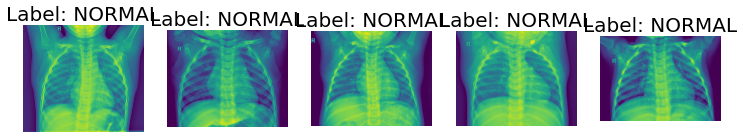

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

# Path to your dataset (adjust accordingly)
data_dir = "/content/drive/MyDrive/train_set"

# Load the dataset
dataset = datasets.ImageFolder('/content/drive/MyDrive/train_set')

# Function to display images
def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img_path, _ = dataset.samples[i]  # Get image path and label
        image = Image.open(img_path)  # Read image using PIL
        axes[i].imshow(image) # Display using matplotlib
        axes[i].set_title(f"Label: {dataset.classes[_]}")
        axes[i].axis('off')
    plt.show()

# Display a few images from the dataset
show_images(dataset)


In [ ]:


#Define the Data Taransformation
transform = transforms.Compose([
    transforms.Resize((224, 224)), #Resiszing the image for Resnet-18 Algorithm implementation from 513 x 512 to 224x224
    transforms.RandomHorizontalFlip(), #Data Augmentation process where the image are randomly roting haorizontally
    transforms.RandomRotation(20),  # data Augmatation process where the image will rotate in a range of  +- 20 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the data Set
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/train_set', transform=transform)
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/train_set', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)







In [ ]:
print('Train dataset size: ', len(train_dataset))
print('Test dataset size: ', len(test_dataset))
class_names = train_dataset.classes
print('Class names: ', class_names)

Train dataset size:  5224
Test dataset size:  5224
Class names:  ['NORMAL', 'PNEUMONIA']


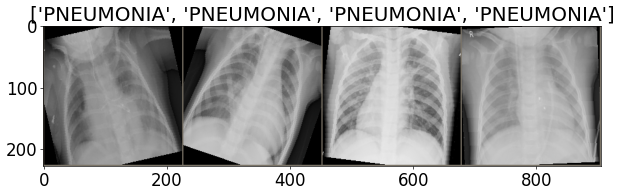

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()
# load a batch of train image
iterator = iter(train_loader)
# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

#Model Development

call Model

In [ ]:
model = models.resnet18(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
num_features = model.fc.in_features
num_features

512

Freeze model

In [ ]:
#Freeze the layers
for param in model.parameters():
    param.requires_grad = False

In [ ]:
for param in model.layer4.parameters():
    param.requires_grad = True

In [ ]:
#Add fully connected layer to model development
model.fc = nn.Linear(num_features, 2)
model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Check if layers are frozen or trainable
for name, param in model.named_parameters():
    print(f"Layer: {name} | Frozen: {not param.requires_grad}")

Layer: conv1.weight | Frozen: True
Layer: bn1.weight | Frozen: True
Layer: bn1.bias | Frozen: True
Layer: layer1.0.conv1.weight | Frozen: True
Layer: layer1.0.bn1.weight | Frozen: True
Layer: layer1.0.bn1.bias | Frozen: True
Layer: layer1.0.conv2.weight | Frozen: True
Layer: layer1.0.bn2.weight | Frozen: True
Layer: layer1.0.bn2.bias | Frozen: True
Layer: layer1.1.conv1.weight | Frozen: True
Layer: layer1.1.bn1.weight | Frozen: True
Layer: layer1.1.bn1.bias | Frozen: True
Layer: layer1.1.conv2.weight | Frozen: True
Layer: layer1.1.bn2.weight | Frozen: True
Layer: layer1.1.bn2.bias | Frozen: True
Layer: layer2.0.conv1.weight | Frozen: True
Layer: layer2.0.bn1.weight | Frozen: True
Layer: layer2.0.bn1.bias | Frozen: True
Layer: layer2.0.conv2.weight | Frozen: True
Layer: layer2.0.bn2.weight | Frozen: True
Layer: layer2.0.bn2.bias | Frozen: True
Layer: layer2.0.downsample.0.weight | Frozen: True
Layer: layer2.0.downsample.1.weight | Frozen: True
Layer: layer2.0.downsample.1.bias | Frozen:

#Model Training





In [ ]:
#define the loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
#Set the random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [ ]:
#### Train model
train_loss=[]
train_accuary=[]
test_loss=[]
test_accuary=[]

num_epochs = 10   #(set no of epochs)
start_time = time.time() #(for showing time)
# Start loop
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0
    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    # Append result
    train_loss.append(epoch_loss)
    train_accuary.append(epoch_acc)
    # Print progress
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time() -start_time))

  #Testing Phase
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data).item()
        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        # Append result
        test_loss.append(epoch_loss)
        test_accuary.append(epoch_acc)
        # Print progress
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time()- start_time))


Epoch 0 running
[Train #1] Loss: 0.0045 Acc: 94.7550% Time: 918.7264s
[Test #1] Loss: 0.0025 Acc: 97.0904% Time: 1578.6975s
Epoch 1 running
[Train #2] Loss: 0.0028 Acc: 96.6501% Time: 2493.4577s
[Test #2] Loss: 0.0016 Acc: 98.0092% Time: 3148.3068s
Epoch 2 running
[Train #3] Loss: 0.0022 Acc: 97.6646% Time: 4062.3602s
[Test #3] Loss: 0.0012 Acc: 98.5452% Time: 4720.3742s
Epoch 3 running
[Train #4] Loss: 0.0016 Acc: 97.9709% Time: 5636.5097s
[Test #4] Loss: 0.0015 Acc: 98.1815% Time: 6294.3139s
Epoch 4 running
[Train #5] Loss: 0.0017 Acc: 98.0858% Time: 7207.4148s
[Test #5] Loss: 0.0010 Acc: 99.0620% Time: 7860.0920s
Epoch 5 running
[Train #6] Loss: 0.0015 Acc: 98.0858% Time: 8772.3234s
[Test #6] Loss: 0.0010 Acc: 98.6600% Time: 9428.3761s
Epoch 6 running
[Train #7] Loss: 0.0012 Acc: 98.6026% Time: 10351.0749s
[Test #7] Loss: 0.0010 Acc: 98.6600% Time: 11004.1572s
Epoch 7 running
[Train #8] Loss: 0.0012 Acc: 98.3538% Time: 11928.3171s
[Test #8] Loss: 0.0011 Acc: 98.8132% Time: 12591.197

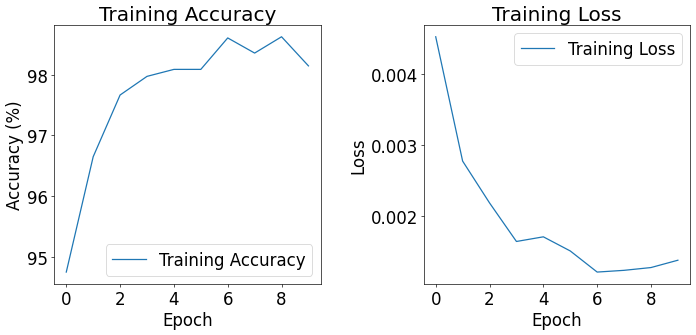

In [ ]:
# prompt: plot the graph of the traing accurcies as well as it loss training only

import matplotlib.pyplot as plt
# Plot training accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuary, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.tight_layout()
plt.show()


Evaluate Model

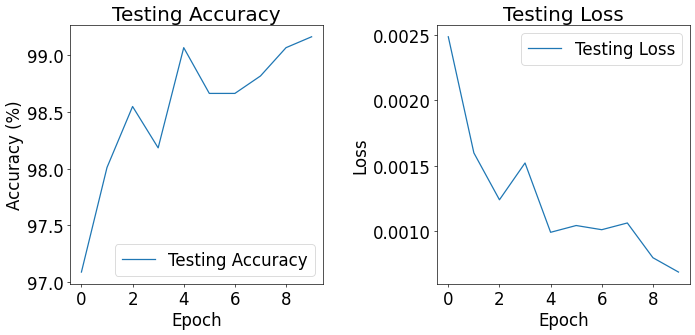

In [ ]:
# prompt: plot the graph of the testing accurcies as well as it loss testing only

import matplotlib.pyplot as plt
# Plot testing accuracy and loss
plt.figure(figsize=(12, 6))

# Plot testing accuracy
plt.subplot(1, 2, 1)
plt.plot(test_accuary, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Testing Accuracy')
plt.legend()

# Plot testing loss
plt.subplot(1, 2, 2)
plt.plot(test_loss, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Testing Loss')
plt.legend()

plt.tight_layout()
plt.show()


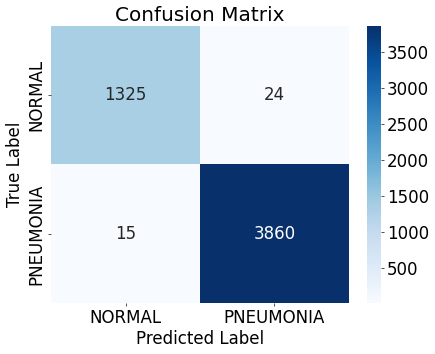

In [ ]:
# prompt: build confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Initialize lists to store true and predicted labels
y_true = []
y_pred = []

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append true and predicted labels
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
#dataiter = iter(test_loader)

In [ ]:
# prompt: produe a labels.txt file that show PNUMONIA IS 1 and Normal is 0

"""with open('labels.txt', 'w') as f:
  f.write('PNEUMONIA IS 1\n')
  f.write('NORMAL IS 0')"""


#Saving the Model

In [ ]:
!pip install h5py

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/ZikryV3_model.pth')

In [ ]:
import h5py

#save model
torch.save(model.state_dict(), '/content/drive/MyDrive/Zikry_model.h5')

#